This Jupyter notebook is used to experiment with the SCHP 2D segmentation model.

In [1]:
!pip install ninja

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 4.3 MB/s eta 0:00:00


In [2]:
!git clone https://github.com/PeikeLi/Self-Correction-Human-Parsing

Cloning into 'Self-Correction-Human-Parsing'...
remote: Enumerating objects: 719, done.
remote: Counting objects: 100% (719/719), done.
remote: Compressing objects: 100% (568/568), done.
remote: Total 719 (delta 149), reused 610 (delta 140), pack-reused 0
Receiving objects: 100% (719/719), 3.88 MiB | 8.52 MiB/s, done.
Resolving deltas: 100% (149/149), done.


In [3]:
import sys
import os
from collections import OrderedDict

import torch
import numpy as np
from PIL import Image
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms

In [4]:
# add repo's path so that the segmentation model can be used
repo_path = "/content/Self-Correction-Human-Parsing"
if (repo_path not in sys.path):
  sys.path.insert(0, repo_path)
print(sys.path)

['/content/Self-Correction-Human-Parsing', '/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython']


In [5]:
# modules and methods for model usage
from networks import init_model
from utils.transforms import transform_logits
from utils.transforms import get_affine_transform
from datasets.simple_extractor_dataset import SimpleFolderDataset

In [6]:
!mkdir inputs
!mkdir outputs
!mkdir checkpoints

In [7]:
dataset_configs = {
    'lip': {
        'num_classes': 20,
        'labels': ['Background', 'Hat', 'Hair', 'Glove', 'Sunglasses', 'Upper-clothes', 'Dress', 'Coat', 'Socks',
                   'Pants', 'Jumpsuits', 'Scarf', 'Skirt', 'Face', 'Left-arm', 'Right-arm', 'Left-leg', 'Right-leg',
                   'Left-shoe', 'Right-shoe'],
        'pretrained_model_download_link': 'https://drive.google.com/uc?id=1k4dllHpu0bdx38J7H28rVVLpU-kOHmnH',
        'pretrained_model_filename': 'pretrained_model_lip.pth'
    },

    'atr': {
        'num_classes': 18,
        'labels': ['Background', 'Hat', 'Hair', 'Sunglasses', 'Upper-clothes', 'Skirt', 'Pants', 'Dress', 'Belt',
                  'Left-shoe', 'Right-shoe', 'Face', 'Left-leg', 'Right-leg', 'Left-arm', 'Right-arm', 'Bag', 'Scarf'],
        'pretrained_model_download_link': 'https://drive.google.com/uc?id=1ruJg4lqR_jgQPj-9K0PP-L2vJERYOxLP',
        'pretrained_model_filename': 'pretrained_model_atr.pth'
    },

    'pascal': {
        'num_classes': 7,
        'labels': ['Background', 'Head', 'Torso', 'Upper Arms', 'Lower Arms', 'Upper Legs', 'Lower Legs'],
        'pretrained_model_download_link': 'https://drive.google.com/uc?id=1E5YwNKW2VOEayK9mWCS3Kpsxf-3z04ZE',
        'pretrained_model_filename': 'pretrained_model_pascal.pth'
    },

    'target': {
        'num_classes': 8,
        'labels': ['Background', 'Head', 'Torso', 'Left Arms', 'Right Arms', 'Upper Legs', 'Left Legs', 'Right Legs']
    }
}


settings = {
    'gpu': '0', # gpu: None or 0,...,etc.

    'input_size': (512, 512),

    'checkpoint_dir': '/content/checkpoints',

    'input_dir': '/content/inputs',

    'output_dir': '/content/outputs',

    'output_image_format': '.png'
}

In [8]:
# load the trained model
import gdown
for name, ds in dataset_configs.items():
    if name == 'target':
        continue
    url = ds['pretrained_model_download_link']
    path = os.path.join(settings['checkpoint_dir'], ds['pretrained_model_filename'])
    gdown.download(url, path, quiet=False)
# url = 'https://drive.google.com/uc?id=1ruJg4lqR_jgQPj-9K0PP-L2vJERYOxLP'
# url = 'https://drive.google.com/uc?id=1E5YwNKW2VOEayK9mWCS3Kpsxf-3z04ZE'
# output = settings['model_restore_path']
# gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1k4dllHpu0bdx38J7H28rVVLpU-kOHmnH
To: /content/checkpoints/pretrained_model_lip.pth
100%|██████████| 267M/267M [00:03<00:00, 76.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ruJg4lqR_jgQPj-9K0PP-L2vJERYOxLP
To: /content/checkpoints/pretrained_model_atr.pth
100%|██████████| 267M/267M [00:04<00:00, 54.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1E5YwNKW2VOEayK9mWCS3Kpsxf-3z04ZE
To: /content/checkpoints/pretrained_model_pascal.pth
100%|██████████| 267M/267M [00:03<00:00, 73.3MB/s]


In [9]:
# obtain input images
%cd inputs
from google.colab import files
uploaded = files.upload()
%cd ..

/content/inputs


Saving 0047_image1.png to 0047_image1.png
/content


In [10]:
# The following methods are adapted from the Self Correction Human Parsing repo.

def get_palette(num_cls):
    """ Returns the color map for visualizing the segmentation mask.
    Args:
        num_cls: Number of classes
    Returns:
        The color map
    """
    n = num_cls
    palette = [0] * (n * 3)
    for j in range(0, n):
        lab = j
        palette[j * 3 + 0] = 0
        palette[j * 3 + 1] = 0
        palette[j * 3 + 2] = 0
        i = 0
        while lab:
            palette[j * 3 + 0] |= (((lab >> 0) & 1) << (7 - i))
            palette[j * 3 + 1] |= (((lab >> 1) & 1) << (7 - i))
            palette[j * 3 + 2] |= (((lab >> 2) & 1) << (7 - i))
            i += 1
            lab >>= 3
    return palette

In [11]:
def plot_save_palette(dataset_name, output_dir, dataset_configs):
    """
    Plot and save the color map using given labels.
    """
    labels = dataset_configs[dataset_name]['labels']
    palette = get_palette(dataset_configs[dataset_name]['num_classes'])
    n = len(labels)
    plt.figure(figsize=(15,5))
    cols = len(labels)
    rows = n // cols + 1
    for i in range(n):
      plt.subplot(rows, cols, i + 1)
      color = np.array(palette[i*3:i*3+3]).reshape(1,1,-1)
      plt.axis('off')
      plt.imshow(color)
      plt.title(labels[i], fontsize=7)
    plt.savefig(os.path.join(output_dir, "label_palette_{}.png".format(dataset_name)))

In [12]:
class CustomDatasetInterface():
    def __init__(self, input_size, transform):
        self.input_size = np.asarray(input_size)
        self.transform = transform
        self.aspect_ratio = input_size[1] * 1.0 / input_size[0]

    def _box2cs(self, box):
        x, y, w, h = box[:4]
        return self._xywh2cs(x, y, w, h)

    def _xywh2cs(self, x, y, w, h):
        center = np.zeros((2), dtype=np.float32)
        center[0] = x + w * 0.5
        center[1] = y + h * 0.5
        if w > self.aspect_ratio * h:
            h = w * 1.0 / self.aspect_ratio
        elif w < self.aspect_ratio * h:
            w = h * self.aspect_ratio
        scale = np.array([w, h], dtype=np.float32)
        return center, scale

    def __preprocess__(self, img, img_name):
        h, w, _ = img.shape

        # Get person center and scale
        person_center, s = self._box2cs([0, 0, w - 1, h - 1])
        r = 0
        trans = get_affine_transform(person_center, s, r, self.input_size)
        input = cv2.warpAffine(
            img,
            trans,
            (int(self.input_size[1]), int(self.input_size[0])),
            flags=cv2.INTER_LINEAR,
            borderMode=cv2.BORDER_CONSTANT,
            borderValue=(0, 0, 0))

        input = self.transform(input)
        meta = {
            'name': img_name,
            'center': person_center,
            'height': h,
            'width': w,
            'scale': s,
            'rotation': r
        }

        return input, meta

class CustomDatasetFromFiles(Dataset, CustomDatasetInterface):
    def __init__(self, root_path, input_size=[512, 512], transform=None):
        CustomDatasetInterface.__init__(self, input_size=input_size, transform=transform)
        self.root_path = root_path
        self.file_list = os.listdir(self.root_path)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        img_name = self.file_list[index]
        # print("Loading " + img_name)
        img_path = os.path.join(self.root_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        return CustomDatasetInterface.__preprocess__(self, img, img_name)

class CustomDatasetFromMemory(Dataset, CustomDatasetInterface):
    def __init__(self, imgs, input_size=[512, 512], transform=None):
        CustomDatasetInterface.__init__(self, input_size=input_size, transform=transform)
        self.imgs = imgs

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, index):
        img = self.imgs[index]
        return CustomDatasetInterface.__preprocess__(self, img, str(index))

In [13]:
# from torchsummary import summary
# tmpmodel = networks.init_model('resnet101', num_classes=20, pretrained=None)
# summary(tmpmodel.cuda(),(3,512,512))

In [14]:
def run_model(model, dataloader, input_size):
    logit_results = []
    class_results = []
    img_names = []
    with torch.no_grad():
        for idx, batch in enumerate(tqdm(dataloader)):
            image, meta = batch
            img_names.append(meta['name'][0])
            c = meta['center'].numpy()[0]
            s = meta['scale'].numpy()[0]
            w = meta['width'].numpy()[0]
            h = meta['height'].numpy()[0]

            # get output upsampled to the input size
            output = model(image.cuda())
            upsample = torch.nn.Upsample(size=input_size, mode='bilinear', align_corners=True)
            upsample_output = upsample(output[0][-1][0].unsqueeze(0))
            upsample_output = upsample_output.squeeze()
            upsample_output = upsample_output.permute(1, 2, 0)  # CHW -> HWC

            # get the corresponding logistic results
            logit_result = transform_logits(upsample_output.data.cpu().numpy(), c, s, w, h, input_size=input_size)
            logit_results.append(logit_result)

            # get the final classifications
            class_result = np.argmax(logit_result, axis=2).astype(np.int32)
            class_results.append(class_result)
    return logit_results, class_results, img_names

def run_2d_image_segmentation(dataset_name, settings, dataset_configs, input_images=None, save_logits=False):
    """
    Args:
        dataset_name: The name of datasets on which the pretrained model is trained. Needs to be a key in dataset_configs.
        settings: Global settings.
        dataset_configs: Dataset configurations.
        input_images: Input images that needs to be segmented. If it is None, input images will be automatically read from the input directory in settings.
        save_logits: Whether to save logistic results.
    Returns:
        The logistic results from segmentation
        The segmentation masks (classifications)
    """
    gpus = [int(i) for i in settings['gpu'].split(',')]
    assert len(gpus) == 1
    if not settings['gpu'] == 'None':
        os.environ["CUDA_VISIBLE_DEVICES"] = settings['gpu']

    input_size = settings['input_size']
    num_classes = dataset_configs[dataset_name]['num_classes']
    labels = dataset_configs[dataset_name]['labels']
    print("Evaluating total class number {} with {}".format(num_classes, labels))

    # define model architecture
    model = init_model('resnet101', num_classes=num_classes, pretrained=None)

    # load trained parameters
    model_load_path = os.path.join(settings['checkpoint_dir'], dataset_configs[dataset_name]['pretrained_model_filename'])
    state_dict = torch.load(model_load_path)['state_dict']
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:]  # remove `module.`
        new_state_dict[name] = v
    model.load_state_dict(new_state_dict)
    model.cuda()
    model.eval()

    # define transforms for input data
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.406, 0.456, 0.485], std=[0.225, 0.224, 0.229])
    ])

    # define input dataset
    if input_images:
        dataset = CustomDatasetFromMemory([input_images], input_size=input_size, transform=transform)
    else:
        dataset = CustomDatasetFromFiles(root_path=settings['input_dir'], input_size=input_size, transform=transform)
    dataloader = DataLoader(dataset)

    # define palette for labels
    palette = get_palette(num_classes)

    # run the model
    logit_results, class_results, img_names = run_model(model, dataloader, input_size)

    # save the logistic results
    if save_logits:
        for logit_result, img_name in zip(logit_results, img_names):
            logit_result_path = os.path.join(settings['output_dir'], 'logits_{0}_{1}.npy'.format(img_name[:-4], dataset_name))
            np.save(logit_result_path, logit_result)

    # save segmentation masks as images
    output_format = settings['output_image_format']
    for seg_mask, img_name in zip(class_results, img_names):
        class_result_path = os.path.join(settings['output_dir'], '{0}_{1}{2}'.format(img_name[:-4], dataset_name, output_format))
        output_img = Image.fromarray(np.asarray(seg_mask, dtype=np.uint8))
        output_img.putpalette(palette)
        output_img.save(class_result_path)

    return logit_results, class_results, img_names

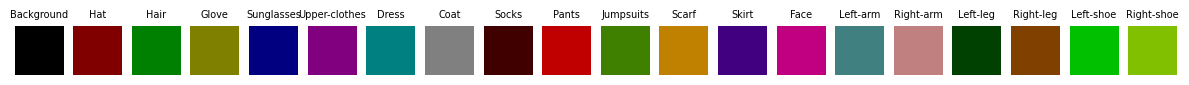

In [15]:
plot_save_palette('lip', settings['output_dir'], dataset_configs)

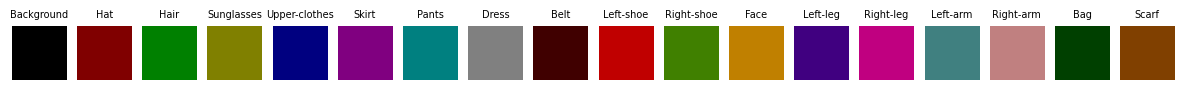

In [16]:
plot_save_palette('atr', settings['output_dir'], dataset_configs)

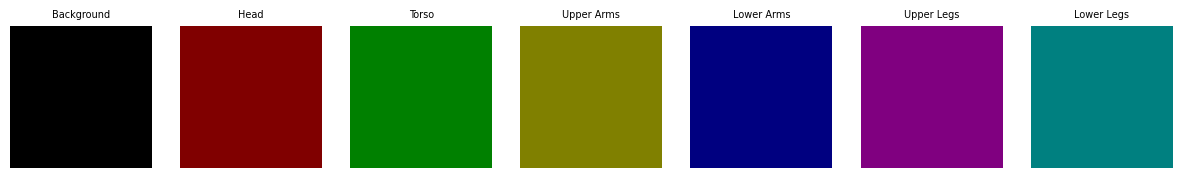

In [17]:
plot_save_palette('pascal', settings['output_dir'], dataset_configs)

In [18]:
def display_image_results(input_list, datasets, settings):
    for fn in input_list:
        for ds in datasets:
            fn_in = fn
            fn_out = fn[:fn.index('.')] + "_{}{}".format(ds, settings['output_image_format'])
            img_in = cv2.cvtColor(cv2.imread(os.path.join(settings['input_dir'], fn_in)), cv2.COLOR_BGR2RGB);
            print(fn_out)
            img_out = cv2.cvtColor(cv2.imread(os.path.join(settings['output_dir'], fn_out)), cv2.COLOR_BGR2RGB);
            h, w, c = img_in.shape
            img_result = np.zeros((h,w*2,c), dtype=np.uint8)
            img_result[:,:w,:] = img_in
            img_result[:,w:,:] = img_out
            plt.imshow(img_result)
            plt.title(fn_out[:fn_out.index('.')])
            plt.axis('off')
            plt.show()

In [19]:
lr1, class_results_1, imgs1 = run_2d_image_segmentation('atr', settings, dataset_configs)
# lr1, class_results_1, imgs1 = run_2d_image_segmentation('lip', settings, dataset_configs)
lr2, class_results_2, imgs2 = run_2d_image_segmentation('pascal', settings, dataset_configs)

Evaluating total class number 18 with ['Background', 'Hat', 'Hair', 'Sunglasses', 'Upper-clothes', 'Skirt', 'Pants', 'Dress', 'Belt', 'Left-shoe', 'Right-shoe', 'Face', 'Left-leg', 'Right-leg', 'Left-arm', 'Right-arm', 'Bag', 'Scarf']


100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Evaluating total class number 7 with ['Background', 'Head', 'Torso', 'Upper Arms', 'Lower Arms', 'Upper Legs', 'Lower Legs']


100%|██████████| 1/1 [00:00<00:00,  7.04it/s]


0047_image1_atr.png


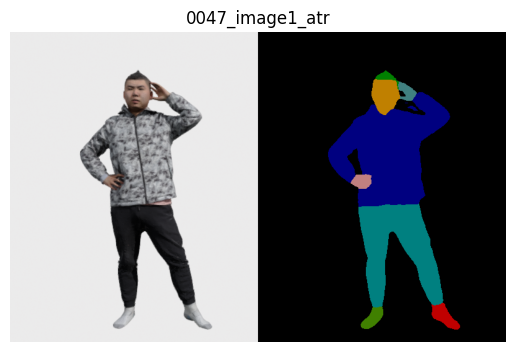

0047_image1_pascal.png


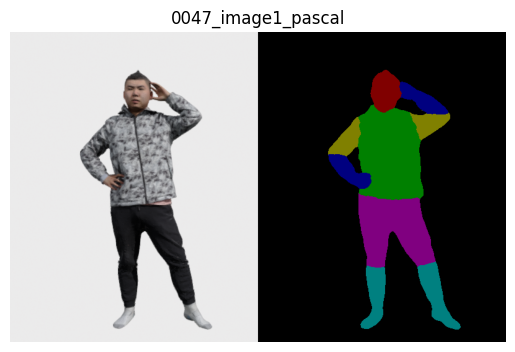

In [20]:
display_image_results(imgs1, ['atr', 'pascal'], settings)

In [21]:
def get_seg_mask_with_palette(seg_mask, palette):
    output_img = Image.fromarray(np.asarray(seg_mask, dtype=np.uint8))
    output_img.putpalette(palette)
    return output_img

In [22]:
def compute_bounding_box_overlapping_area(min_r_a, min_c_a, max_r_a, max_c_a, min_r_b, min_c_b, max_r_b, max_c_b):
    height = max(min(max_r_a, max_r_b) - max(min_r_a, min_r_b), 0)
    width = max(min(max_c_a, max_c_b) - max(min_c_a, min_c_b), 0)
    return height * width

def extend_left_right_coloring(position_mask, position_label, target_mask, left_label, right_label):
    '''
    "position" indicates the position of arms/legs to be colored.
    "target_mask" indicates the desired labels (with left and right information).

    First find out the positions that need to be recolored to show left or
    right (the positions of arms/legs). Then map these positions to the
    target_mask. Note that target_mask already have information about left and
    right. Lastly, extend such existing colored areas to fill the desired
    positions obtained in the first step.

    Note this method modifies target_mask in place.

    This method returns False when the condition is not desirable, i.e. when
    this method cannot work correctly. If it works successfully, it returns
    True.
    '''

    obtained_valid_results = True

    # offset for bounding boxes to ensure overlaps
    offset = 5

    # seperate two sets of arms/legs (find two clusters of arms/legs)
    h, w = position_mask.shape
    seperation_mask = np.zeros((h,w), dtype=np.bool8)
    inds = np.argwhere(position_mask == position_label)
    if len(inds) == 0:
        return False
    start_ind = inds[len(inds)//2]
    queue = [start_ind]
    min_r, min_c = start_ind
    max_r, max_c = start_ind
    seperation_mask[start_ind[0], start_ind[1]] = True
    while len(queue) > 0:
        row, col = queue.pop(0)
        for r in range(max(row-1,0), min(row+2,h)):
            for c in range(max(col-1,0), min(col+2,w)):
                if (not seperation_mask[r,c]) and (position_mask[r,c] == position_label):
                    seperation_mask[r,c] = True
                    queue.append((r,c))
                    min_r = min(min_r, r)
                    min_c = min(min_c, c)
                    max_r = max(max_r, r)
                    max_c = max(max_c, c)

    # find the left/right labels to the two sets
    inds = np.argwhere(target_mask == left_label)
    bb = min_r, min_c, max_r, max_c
    missing_left = False
    missing_right = False

    if len(inds) == 0: # no such labels for left side
        area_with_left = 0
        missing_left = True
    else:
        left_min_r = max(inds[:,0].min()-offset, 0)
        left_min_c = max(inds[:,1].min()-offset, 0)
        left_max_r = min(inds[:,0].max()+offset, h-1)
        left_max_c = min(inds[:,1].max()+offset, w-1)
        left_bb = left_min_r, left_min_c, left_max_r, left_max_c
        area_with_left = compute_bounding_box_overlapping_area(*bb, *left_bb)
    inds = np.argwhere(target_mask == right_label)

    if len(inds) == 0: # no such labels for right side
        area_with_right = 0
        missing_right = True
    else:
        right_min_r = max(inds[:,0].min()-offset, 0)
        right_min_c = max(inds[:,1].min()-offset, 0)
        right_max_r = min(inds[:,0].max()+offset, h-1)
        right_max_c = min(inds[:,1].max()+offset, w-1)
        right_bb = right_min_r, right_min_c, right_max_r, right_max_c
        area_with_right = compute_bounding_box_overlapping_area(*bb, *right_bb)

    if missing_left and missing_right:
        label1 = left_label
        label2 = left_label
        obtained_valid_results = False
    else:
        if area_with_left >= area_with_right:
            label1 = left_label
            label2 = right_label
        else:
            label1 = right_label
            label2 = left_label

    # assign the spacial labels
    set1 = seperation_mask & (position_mask == position_label)
    set2 = (~seperation_mask) & (position_mask == position_label)
    # if position_label == 3:
    #     print(start_ind)
    #     print(area_with_left)
    #     print(area_with_right)
    #     print(*bb)
    #     print(*left_bb)
    #     print(*right_bb)
    #     print(np.sum(set1))
    #     plt.imshow(position_mask)
    #     import matplotlib.patches as patches
    #     rec = patches.Rectangle((min_c,min_r),max_c-min_c,max_r-min_r,linewidth=1,edgecolor='r',facecolor='none')
    #     rec1 = patches.Rectangle((left_min_c,left_min_r),left_max_c-left_min_c,left_max_r-left_min_r,linewidth=1,edgecolor='r',facecolor='none')
    #     rec2 = patches.Rectangle((right_min_c,right_min_r),right_max_c-right_min_c,right_max_r-right_min_r,linewidth=1,edgecolor='r',facecolor='none')
    #     plt.gca().add_patch(rec)
    #     plt.gca().add_patch(rec1)
    #     plt.gca().add_patch(rec2)
    #     plt.show()
    target_mask[set1] = label1
    target_mask[set2] = label2

    return obtained_valid_results

In [23]:
print(imgs1)
os.listdir(settings['input_dir'])

['0047_image1.png']


['0047_image1.png']

In [24]:
def get_left_right_labeled_results(pascal_results, atr_results, dataset_configs):
    '''
    Given two batches of segmentation masks (outputs from models based on Pascal
    Dataset and ATR Dataset), try to merget them together to get one batch of
    segmentation masks where left arms, right arms, left legs, and right legs
    are seperately labeled.

    In Pascal Dataset, upper arms, lower arms, upper legs, and lower arms can be
    labeled, but there is no left or right information.

    In ATR Dataset, most of the time, only left hands, right hands, left shoes,
    and right shoes can be labeled, but not arms or legs (when arms and legs are
    covered by clothing).
    '''
    pascal_lower_arms_label = dataset_configs['pascal']['labels'].index('Lower Arms')
    pascal_upper_arms_label = dataset_configs['pascal']['labels'].index('Upper Arms')
    pascal_lower_legs_label = dataset_configs['pascal']['labels'].index('Lower Legs')
    pascal_upper_legs_label = dataset_configs['pascal']['labels'].index('Upper Legs')
    atr_left_arms_label = dataset_configs['atr']['labels'].index('Left-arm')
    atr_right_arms_label = dataset_configs['atr']['labels'].index('Right-arm')
    atr_left_legs_label = dataset_configs['atr']['labels'].index('Left-shoe')
    atr_right_legs_label = dataset_configs['atr']['labels'].index('Right-shoe')
    # atr_left_arms_label = dataset_configs['lip']['labels'].index('Left-arm')
    # atr_right_arms_label = dataset_configs['lip']['labels'].index('Right-arm')
    # atr_left_legs_label = dataset_configs['lip']['labels'].index('Left-shoe')
    # atr_right_legs_label = dataset_configs['lip']['labels'].index('Right-shoe')

    target_left_arms_label = dataset_configs['target']['labels'].index('Left Arms')
    target_right_arms_label = dataset_configs['target']['labels'].index('Right Arms')
    target_left_legs_label = dataset_configs['target']['labels'].index('Left Legs')
    target_right_legs_label = dataset_configs['target']['labels'].index('Right Legs')

    combined_results = []
    for pascal_result, atr_result in zip(pascal_results, atr_results):
        combined_result = np.zeros(pascal_result.shape)

        # mapping from Pascal labels to customized labels
        # leave newly created labels as 0 (not exist in Pascal labels)
        for new_label, name in enumerate(dataset_configs['target']['labels']):
            if name in dataset_configs['pascal']['labels']:
                old_label = dataset_configs['pascal']['labels'].index(name)
                combined_result[pascal_result == old_label] = new_label

        # put initial left and right labels on the combined results
        # left and right information is obtained from ATR results
        combined_result[atr_result == atr_left_arms_label] = target_left_arms_label
        combined_result[atr_result == atr_right_arms_label] = target_right_arms_label
        combined_result[atr_result == atr_left_legs_label] = target_left_legs_label
        combined_result[atr_result == atr_right_legs_label] = target_right_legs_label

        combined_results.append(combined_result)

    # distinguish between left arms and right arms
    for i in range(len(pascal_results)):
        # color lower arms from hands
        extend_left_right_coloring(pascal_results[i], pascal_lower_arms_label, combined_results[i], target_left_arms_label, target_right_arms_label)
        # color lower legs from shoes
        extend_left_right_coloring(pascal_results[i], pascal_lower_legs_label, combined_results[i], target_left_legs_label, target_right_legs_label)
        # color upper arms from hands
        extend_left_right_coloring(pascal_results[i], pascal_upper_arms_label, combined_results[i], target_left_arms_label, target_right_arms_label)

    return combined_results

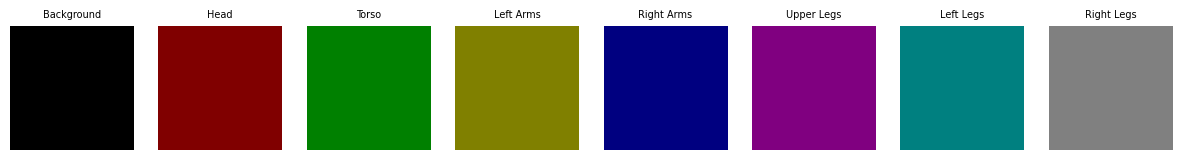

In [25]:
plot_save_palette('target', settings['output_dir'], dataset_configs)

In [26]:
combined_results = get_left_right_labeled_results(class_results_2, class_results_1, dataset_configs)

In [27]:
np.unique(combined_results[0])

array([0., 1., 2., 3., 4., 5., 6., 7.])

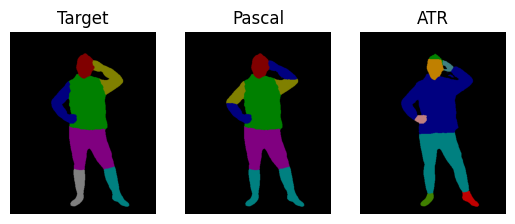

In [28]:
for i in range(len(combined_results)):
    out_img1 = get_seg_mask_with_palette(combined_results[i], get_palette(dataset_configs['target']['num_classes']))
    out_img2 = get_seg_mask_with_palette(class_results_2[i], get_palette(dataset_configs['pascal']['num_classes']))
    out_img3 = get_seg_mask_with_palette(class_results_1[i], get_palette(dataset_configs['atr']['num_classes']));
    # out_img3 = get_seg_mask_with_palette(class_results_1[i], get_palette(dataset_configs['lip']['num_classes']));
    plt.subplot(1,3,1)
    plt.imshow(out_img1)
    plt.axis('off')
    plt.title("Target")
    plt.subplot(1,3,2)
    plt.imshow(out_img2)
    plt.axis('off')
    plt.title("Pascal")
    plt.subplot(1,3,3)
    plt.imshow(out_img3)
    plt.title("ATR")
    plt.axis('off')
    plt.show()
    img_name = imgs1[i][:imgs1[i].index('.')]
    img_fn = img_name + "_segmask.png"

    w, h = out_img1.size
    out_img1_rgb = np.zeros((h,w,3))
    out_img1 = np.asarray(out_img1)
    num_classes = dataset_configs['target']['num_classes']
    palette = get_palette(dataset_configs['target']['num_classes'])
    for i in range(num_classes):
        # print(out_img1_rgb[out_img1_rgb[:,:,0] == i, :].shape)
        out_img1_rgb[out_img1[:,:] == i, :] = palette[i*3:i*3+3]
        # print(palette[i:i+3])
        # print(np.unique(out_img1_rgb[out_img1[:,:] == i, :],axis=0))
    #     # print()
    # print(out_img1_rgb.shape)
    # unique = np.unique(np.asarray(out_img1_rgb).reshape(-1,3), axis=0)
    # print(len(unique))
    matplotlib.image.imsave(img_fn, out_img1_rgb.astype(np.uint8))

    matrix_fn = img_name + "_segmask.npy"
    np.save(matrix_fn, out_img1_rgb)

In [29]:
#!zip segmasks.zip ./*_segmask.npy